In [25]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import sys
path = str(Path(Path('File.py').parent.absolute()).parent.absolute())
sys.path.insert(0, path)

import numpy as np
import matplotlib as mlab
import matplotlib.pyplot as plt
import xarray as xr
import os as os
import glob
import matplotlib.gridspec as gridspec
from collections import namedtuple

#from Plot_tools import *
from File_tools import *

import pickle

_nthreads = 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
w_thresh = 5.0
cref_thresh = 35.
percent = (50,90,95)

in_dir  = "/work/wicker/Odin_scr/solo"
out_dir = "/work/wicker/Odin_scr/solo"
prefix  = {"solo": "squall_remap", "wrf": "squall_3km", "cm1": "squall_3km"}

allcape = ("C2000", "C3500")
allshear = ("06", "12", "18")

solo  = {}
ssolo = {}
cm1   = {}
scm1  = {}
wrf   = {}
swrf  = {}

for shear in allshear:
    for cape in allcape:
        
        label = "%s_%s" % (cape, shear)

#         solo_file = str(os.path.join(in_dir, "%s_%s" % (prefix['solo'], label)))
#         solo[label], ssolo[label] = generate_ideal_profiles(solo_file, filename="atmos_hifreq.nc", model_type='fv3_solo', w_thresh = w_thresh, cref_thresh = cref_thresh, 
#                                                             percentiles=percent, zhgts = 250. + 250.*np.arange(100))
        
#         wrf_file = str(os.path.join("/work/wicker/WRF/WRF/test/em_quarter_ss", "%s_%s" % (prefix['wrf'], label)))
#         wrf[label], swrf[label] = generate_ideal_profiles(wrf_file, model_type='wrf', w_thresh = w_thresh, cref_thresh = cref_thresh, 
#                                                           percentiles=percent, compDBZ=True, zhgts = 250. + 250.*np.arange(100))
                 
        cm1_file = str(os.path.join("/work/wicker/Odin_scr/cm1r20.3/run", "%s_%s" % (prefix['cm1'], label)))
        cm1[label], scm1[label] = generate_ideal_profiles(cm1_file, model_type='cm1', w_thresh = w_thresh, cref_thresh = cref_thresh, 
                                                          percentiles=percent, zhgts = 250. + 250.*np.arange(100))
            
# with open('%s_profiles.pkl' % prefix['solo'], 'wb') as handle:
#     pickle.dump(solo, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('%s_sizes.pkl' % prefix['solo'], 'wb') as handle:
#     pickle.dump(ssolo, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('wrf_profiles.pkl', 'wb') as handle:
#     pickle.dump(wrf, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# with open('wrf_sizes.pkl', 'wb') as handle:
#     pickle.dump(swrf, handle, protocol=pickle.HIGHEST_PROTOCOL)
     
with open('cm1_profiles.pkl', 'wb') as handle:
    pickle.dump(cm1, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('cm1_sizes.pkl', 'wb') as handle:
    pickle.dump(scm1, handle, protocol=pickle.HIGHEST_PROTOCOL)



processing model run:  /work/wicker/Odin_scr/cm1r20.3/run/squall_3km_C2000_06 

Reading:  /work/wicker/Odin_scr/cm1r20.3/run/squall_3km_C2000_06/cm1out.nc 

Reading existing DBZ file in directory

 Number of selected updraft profiles:  540 
 Number of labeled objects:  564

Percentile value:  50.000000

Percentile value:  90.000000

Percentile value:  95.000000

processing model run:  /work/wicker/Odin_scr/cm1r20.3/run/squall_3km_C3500_06 

Reading:  /work/wicker/Odin_scr/cm1r20.3/run/squall_3km_C3500_06/cm1out.nc 

Reading existing DBZ file in directory

 Number of selected updraft profiles:  1445 
 Number of labeled objects:  1469

Percentile value:  50.000000

Percentile value:  90.000000

Percentile value:  95.000000

processing model run:  /work/wicker/Odin_scr/cm1r20.3/run/squall_3km_C2000_12 

Reading:  /work/wicker/Odin_scr/cm1r20.3/run/squall_3km_C2000_12/cm1out.nc 

Reading existing DBZ file in directory

 Number of selected updraft profiles:  444 
 Number of labeled objects:

In [36]:
# Just read stuff back in...
            
cm1 = pickle2Obj('cm1_profiles.pkl',retObj=False)
wrf = pickle2Obj('wrf_profiles.pkl',retObj=False)
fv3 = pickle2Obj('%s_profiles.pkl' % prefix['solo'],retObj=False)


In [40]:
print(cm1[label[0]][0].shape)

(100, 1445)


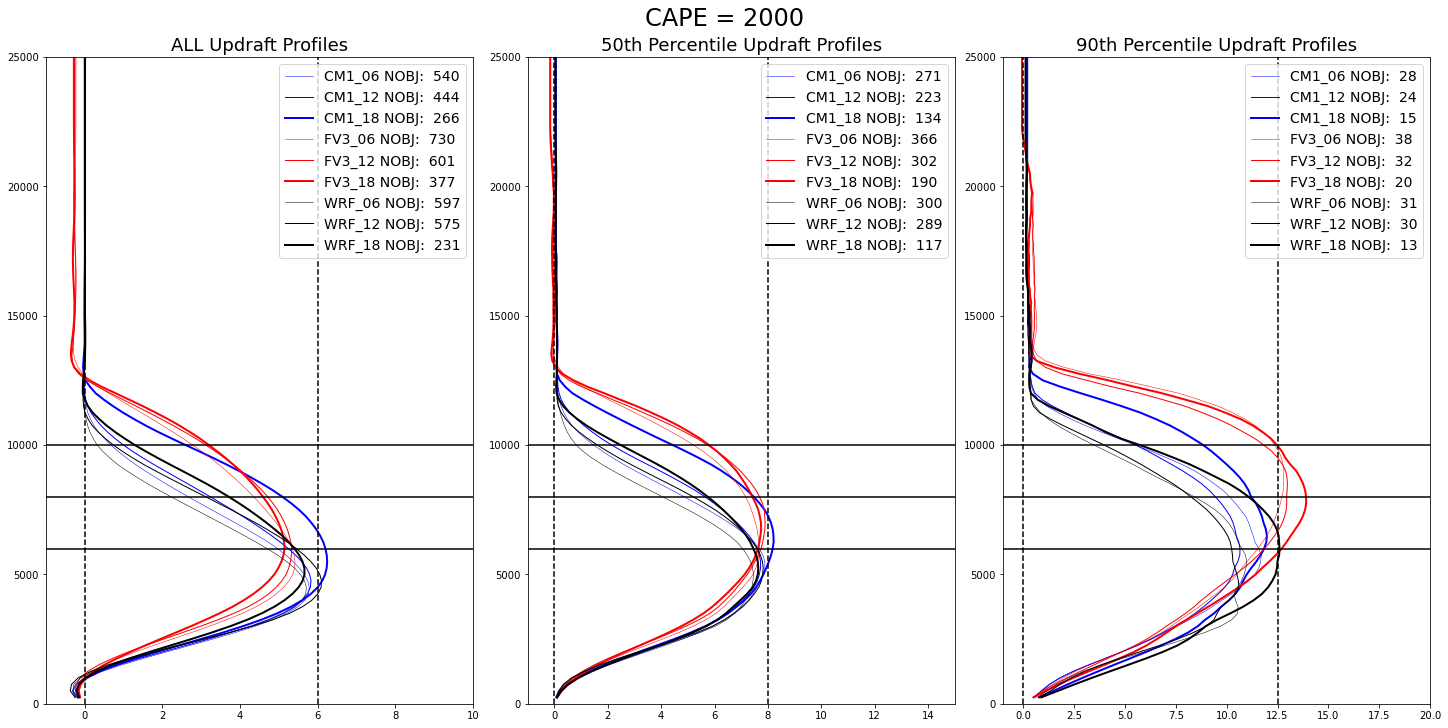

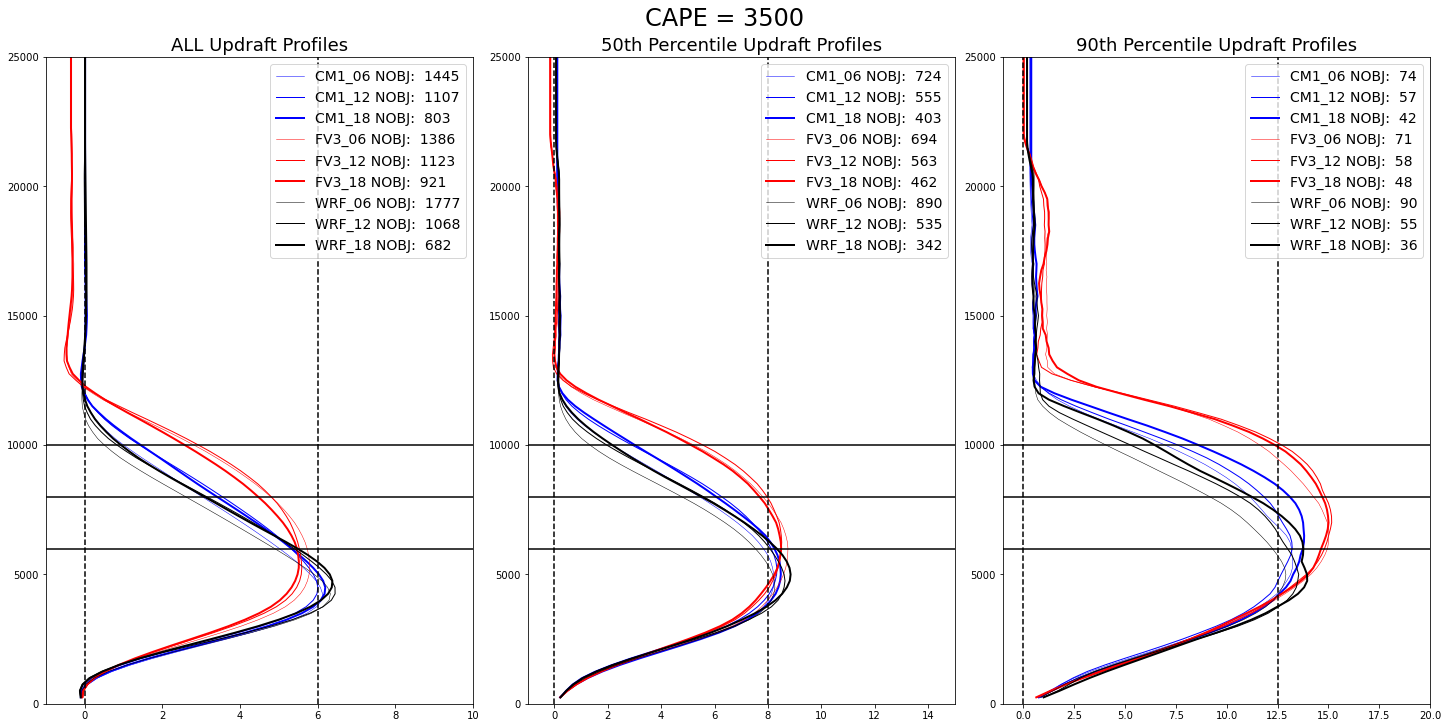

In [39]:
#--------------------------------------------------------------------------------------------
def plot_wprofile(profile, zhgts, percentile, ax, color, mlabel, linewidth=2.0, linestyle='solid'):

    label = "%s NOBJ:  %d" % (mlabel, profile[percentile].shape[1])
    
    ax.plot(profile[percentile].mean(axis=1), zhgts, color=color, linewidth=linewidth, label=label, linestyle=linestyle)
#--------------------------------------------------------------------------------------------
# main

titles = ["ALL Updraft Profiles", "50th Percentile Updraft Profiles", "90th Percentile Updraft Profiles"]

xvert  = [6.0, 8.0, 12.5]
xlim   = [10., 15.0, 20.0]

zhgts = 250. + 250.*np.arange(100)

allcape = ( "C2000", "C3500")
allshear = ("06", "12", "18")

for cape in allcape:
    
    label = []
    
    for shear in allshear:   # create dictionary names
        
        label.append("%s_%s" % (cape, shear))
            
    fig, ax = plt.subplots(1,3, constrained_layout=True,figsize=(20,10))

    for m in [0,1,3]:
            
        n = m
        if m == 3: n=2

        plot_wprofile(cm1[label[0]], zhgts, m, ax[n], 'b', 'CM1_06', linewidth=0.5)
        plot_wprofile(cm1[label[1]], zhgts, m, ax[n], 'b', 'CM1_12', linewidth=1.0)
        plot_wprofile(cm1[label[2]], zhgts, m, ax[n], 'b', 'CM1_18', linewidth=2.0)

        plot_wprofile(fv3[label[0]], zhgts, m, ax[n], 'r', 'FV3_06', linewidth=0.5)
        plot_wprofile(fv3[label[1]], zhgts, m, ax[n], 'r', 'FV3_12', linewidth=1.0)
        plot_wprofile(fv3[label[2]], zhgts, m, ax[n], 'r', 'FV3_18', linewidth=2.0)
                         
        plot_wprofile(wrf[label[0]], zhgts, m, ax[n], 'k', 'WRF_06', linewidth=0.5)
        plot_wprofile(wrf[label[1]], zhgts, m, ax[n], 'k', 'WRF_12', linewidth=1.0)
        plot_wprofile(wrf[label[2]], zhgts, m, ax[n], 'k', 'WRF_18', linewidth=2.0)
    
        ax[n].set_title("%s" % titles[n], fontsize=18)
        ax[n].axhline(y=6000., color='k', linestyle='-')
        ax[n].axhline(y=8000., color='k', linestyle='-')
        ax[n].axhline(y=10000., color='k', linestyle='-')
        ax[n].axvline(x=0.0, color='k', linestyle='--')
        ax[n].axvline(x=xvert[n], color='k', linestyle='--')

        ax[n].set_ylim(0.0,25000.)
        ax[n].set_xlim(-1.0,xlim[n])
        ax[n].legend(fontsize=14, loc='upper right')

    plt.suptitle("CAPE = %s" % cape[1:], fontsize=24)
    plt.show()

In [6]:
# Just read stuff back in...
            
cm1 = pickle2Obj('cm1_sizes.pkl',retObj=False)
wrf = pickle2Obj('wrf_sizes.pkl',retObj=False)
solo = pickle2Obj('%s_sizes.pkl' % prefix['solo'],retObj=False)




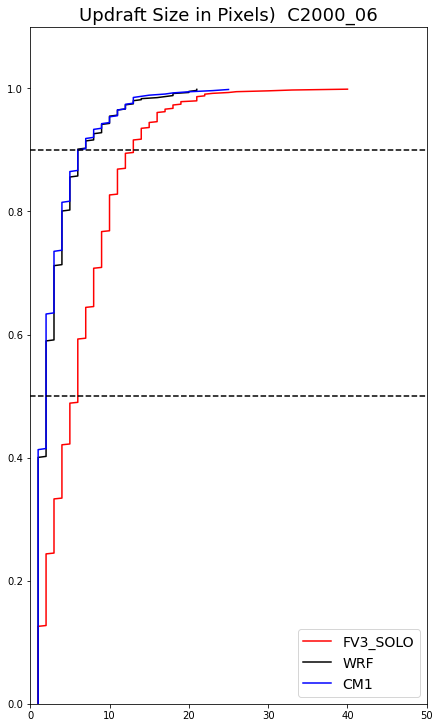

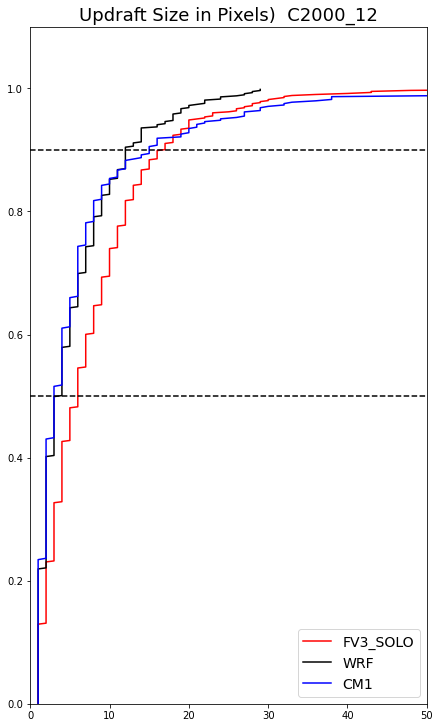

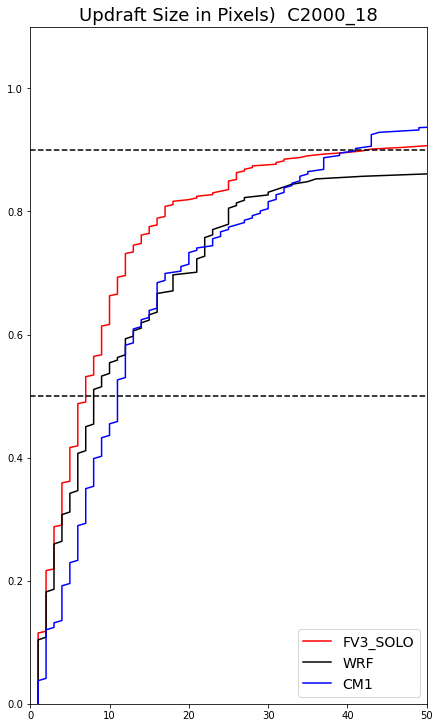

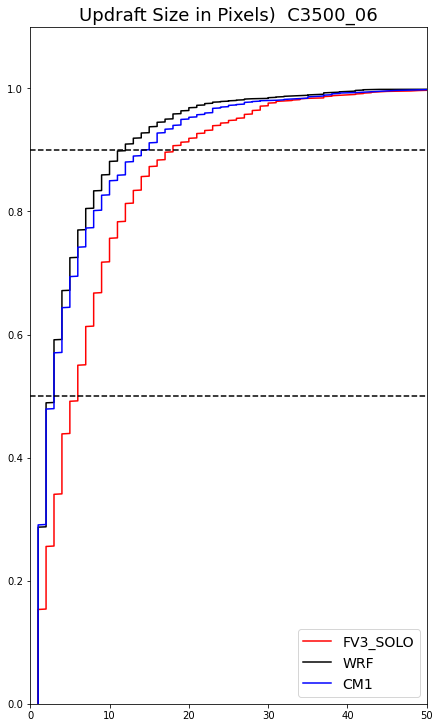

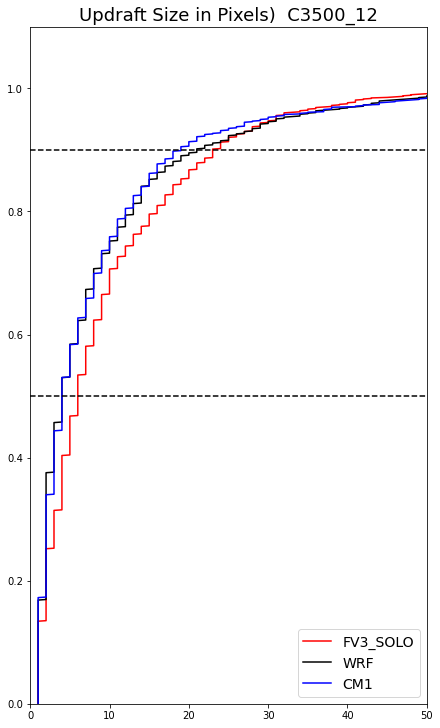

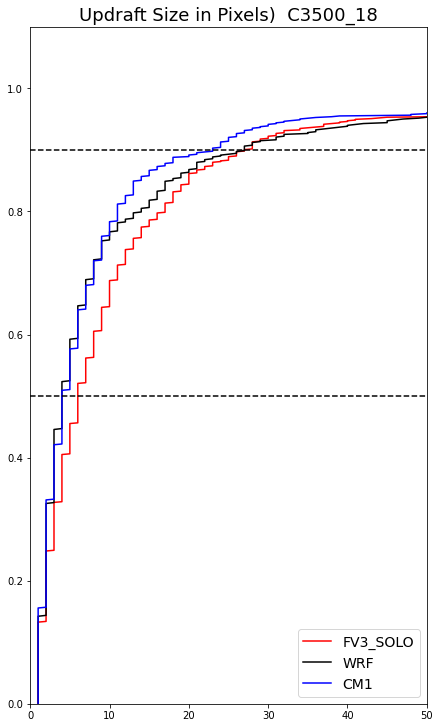

In [7]:
allcape = ("C2000", "C3500")
allshear = ("06","12", "18")



for cape in allcape:
        
    for shear in allshear:   # create dictionary names
        
        label = "%s_%s" % (cape, shear)
                    
        fig, ax = plt.subplots(1,1, constrained_layout=True,figsize=(6,10))

        zsolo = np.arange(len(solo[label]))/float(len(solo[label]))
        
        zwrf = np.arange(len(wrf[label]))/float(len(wrf[label]))
        
        zcm1 = np.arange(len(cm1[label]))/float(len(cm1[label]))
        
        ax.plot(solo[label], zsolo, color='r', label='FV3_SOLO')
        ax.plot(wrf[label], zwrf, color='k', label='WRF')
        
        ax.plot(cm1[label], zcm1, color='b', label='CM1')
        
        ax.set_title("%s  %s" % ("Updraft Size in Pixels)", label), fontsize=18)
        ax.axhline(y=0.5, color='k', linestyle='--')
        ax.axhline(y=0.9,  color='k', linestyle='--')

        ax.set_ylim(0.0,1.1)
        ax.set_xlim(0,50)
        ax.legend(fontsize=14, loc='lower right')
